# arXiv heatmaps

We study the time-series linear models to make short-term predictions, following the sklearn [time-related feature engineering guide](https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html).

First, we load the data from `data/arxiv-totals.parquet`.

In [ ]:
import pandas as pd

df = pd.read_parquet("../data/arxiv-totals.parquet")

Because the arXiv was still picking up, we have decided to ignore all dates before Jan 1, 2001.  We are also taking our training sample to end on Fri Mar 14, 2025 (included), and our testing sample to start from Mon Mar 17, 2025.

In [ ]:
df_train = df[
    (df.index >= pd.Timestamp(2001, 1, 1)) & (df.index <= pd.Timestamp(2025, 3, 14))
]
df_test = df[df.index >= pd.Timestamp(2025, 3, 17)]

To get a sense of how these look like, we plot the submissions from the `math` category.

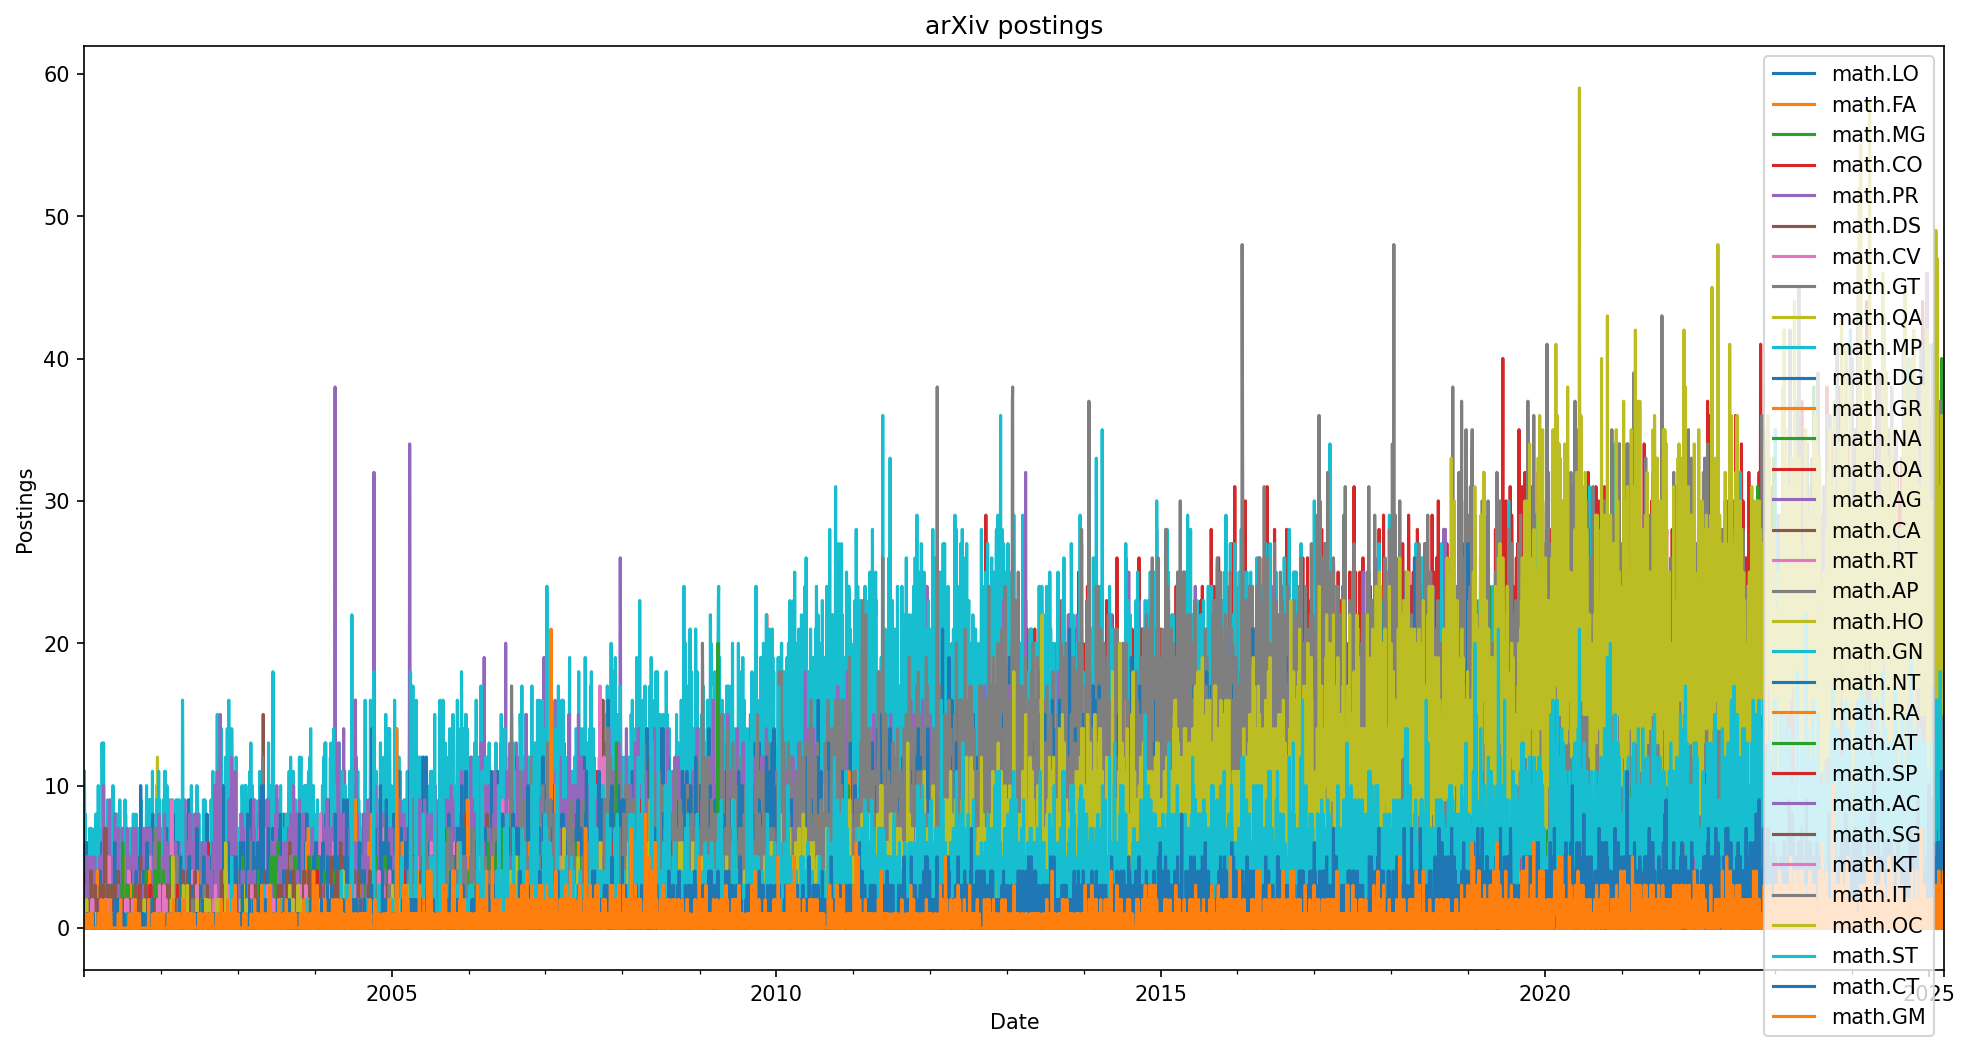

In [ ]:
import matplotlib.pyplot as plt

# set plot size
plt.figure(figsize=(16, 8), dpi=150)

# adding the plots
for label, content in df_train.items():
    if label.startswith("math."):  # type: ignore
        content.plot(label=label)

# adding title to the plot
plt.title("arXiv postings")

# adding labels
plt.xlabel("Date")
plt.ylabel("Postings")

# adding legend to the curve
plt.legend()

We also plot `hep-ph` by itself.

Text(0, 0.5, 'Postings')

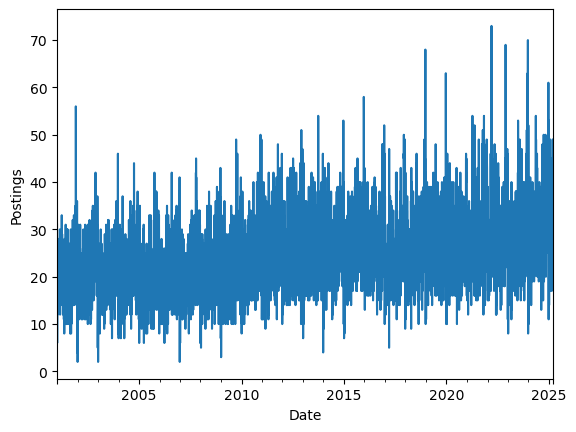

In [ ]:
df_train["hep-ph"].plot()
plt.xlabel("Date")
plt.ylabel("Postings")

We now prepare a 5-fold validation.  We take a gap of 5 business days between train and validation splits, and we take a test size of 15 business days (our forecasting horizon is 5 business days).

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

ts_cv = TimeSeriesSplit(n_splits=5, gap=5, test_size=15)

splits = list(ts_cv.split(df_train))

## Models comparison

Our baseline model is just taking predicting the average in the training set.  We compare that to a simple linear regression.

In [ ]:
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
import numpy as np

dummy_reg = DummyRegressor(strategy="mean")
lin_reg = LinearRegression()

mean_rmses = np.zeros(5)
lin_rmses = np.zeros(5)

for i, (train_index, test_index) in enumerate(splits):
    # prepare train data
    df_tt = df_train.iloc[train_index, :]
    df_tt.reset_index(inplace=True)
    df_tt.reset_index(
        inplace=True
    )  # reset index twice to get a column of indexes to use as feature

    # prepare validation data
    df_holdout = df_train.iloc[test_index, :]
    df_holdout.reset_index(inplace=True)
    df_holdout.reset_index(inplace=True)

    # fit the models
    dummy_reg.fit(df_tt[["index"]], df_tt["hep-th"])
    mean_preds = dummy_reg.predict(df_holdout[["index"]])

    lin_reg.fit(df_tt[["index"]], df_tt["hep-th"])
    lin_preds = lin_reg.predict(df_holdout[["index"]])

    mean_rmses[i] = root_mean_squared_error(df_holdout["hep-th"], mean_preds)
    lin_rmses[i] = root_mean_squared_error(df_holdout["hep-th"], lin_preds)

print(mean_rmses)
print(lin_rmses)

[16.00557923 20.80061004  6.98843906  6.50578033 10.39061702]
[21.75200046 23.9373214  11.64313321 12.006453   16.12015374]
